In [1]:
import asyncio
import ccxt
# import ccxt.async_support as ccxt # link against the asynchronous version of ccxt
import pandas as pd
import os
import datetime
import pandas_ta as ta
from ccxt.base.exchange import Exchange
import numpy as np

ModuleNotFoundError: No module named 'ccxt'

In [7]:
# All available exchange classes
# print(ccxt.exchanges) 

## Kraken Cryptos features (Part A)

In [6]:
#web scraping method
url ="https://coinmarketcap.com/all/views/all/"
coinmarket_url_df= pd.read_html(url)
mc_df=coinmarket_url_df[2:]
mc_df=mc_df[0]
mc_df.dtypes
mc_df['market_cap']=mc_df['Market Cap'].str.replace('$', '')
mc_df['market_cap']=mc_df['market_cap'].str.replace(',', '').astype('float')
mc_df['price']=mc_df['Price'].str.replace('$', '')
mc_df['price']=mc_df['price'].str.replace(',', '').astype('float')
mc_df['circulating_suppy']=mc_df.market_cap/mc_df.price
mc_df['volume_24h']=mc_df['Volume (24h)'].str.replace('$', '')
mc_df['volume_24h']=mc_df['volume_24h'].str.replace(',', '').astype('float')
cm_crypto_features_df=mc_df.drop(columns=['Name','Rank','Market Cap','Price','Circulating Supply','Volume (24h)','% 1h','% 24h','% 7d','Unnamed: 10',],axis=1)
cm_crypto_features_df.head()

,Symbol,market_cap,price,circulating_suppy,volume_24h
0,BTC,1.709464e+11,9275.290000,1.843030e+07,1.325811e+10
1,ETH,2.689668e+10,240.750000,1.117204e+08,5.605297e+09
2,USDT,9.195400e+09,1.000000,9.195400e+09,1.683792e+10
3,XRP,8.934714e+09,0.201879,4.425777e+10,9.407886e+08
4,BCH,4.396195e+09,238.150000,1.845977e+07,8.456606e+08


## Create list of tickers to pull data from Kraken

In [7]:
cm_crypto_features_df['ticker']=cm_crypto_features_df.Symbol+'/USD'
tickers=cm_crypto_features_df.ticker.values.tolist()
len(tickers)

200

## Import data from Kraken

In [8]:
# Import environment variables
KRAKEN_PUBLIC_KEY = os.getenv('KRAKEN_PUBLIC_KEY')
KRAKEN_SECRET_KEY = os.getenv('KRAKEN_SECRET_KEY')

In [9]:
#Pull data from kraken
# Set the public and private keys for the API
exchange = ccxt.kraken({
    'apiKey': KRAKEN_PUBLIC_KEY,
    'secret': KRAKEN_SECRET_KEY,
})
since = exchange.parse8601('2020-01-01T00:00:00z')
cols=['time','open','high','low','close','volume','ticker']
symbols = tickers
timeframe='1d'
crypto_returns_df1= []
for i in symbols:
    try:
        price_batch = pd.DataFrame(exchange.fetchOHLCV(i,timeframe, since, params = {}))
        price_batch[6]=i
        price_batch[0] = pd.to_datetime(price_batch[0], unit="ms")
        crypto_returns_df1.append(price_batch)
    except Exception:
        cryptos_historic_df_kraken = pd.concat(crypto_returns_df1)
        cryptos_historic_df_kraken.columns=cols

In [10]:
cryptos_historic_df_kraken.head()

,time,open,high,low,close,volume,ticker
0,2020-01-01,7168.3,7235.0,7150.0,7174.4,1826.411607,BTC/USD
1,2020-01-02,7174.4,7185.8,6915.0,6942.3,4052.409028,BTC/USD
2,2020-01-03,6942.3,7397.3,6860.0,7334.8,8082.003268,BTC/USD
3,2020-01-04,7333.2,7396.4,7260.0,7350.2,2907.493439,BTC/USD
4,2020-01-05,7350.2,7493.3,7301.1,7346.9,2900.397843,BTC/USD


In [11]:
#Full df of cryptos
crypto_close_kraken= cryptos_historic_df_kraken.drop(columns=['open','high','low','volume'],axis=1)
crypto_close_kraken= crypto_close_kraken.pivot_table(index='time', columns='ticker', values='close', aggfunc='mean')
crypto_close_kraken.sort_index(ascending=True).head(50)
len(crypto_close_kraken.columns)

32

In [12]:
#cryptos df with same lenght of historic data
filter_cryptos=pd.DataFrame(len(crypto_close_kraken) - crypto_close_kraken.count())
filter_cryptos=list(filter_cryptos[filter_cryptos[0]==0].index.values)
len(filter_cryptos)

29

In [13]:
crypto_close_df=crypto_close_kraken[filter_cryptos]
crypto_close_df.head()

ticker,ADA/USD,ATOM/USD,BAT/USD,BCH/USD,BTC/USD,DAI/USD,DASH/USD,DOGE/USD,EOS/USD,ETC/USD,...,QTUM/USD,REP/USD,SC/USD,USDT/USD,WAVES/USD,XLM/USD,XMR/USD,XRP/USD,XTZ/USD,ZEC/USD
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.033411,4.3701,0.19543,203.5,7174.4,0.99482,41.811,0.002007,2.5788,4.489,...,1.59885,8.654,0.00130,0.9970,1.0457,0.045192,45.62,0.19269,1.3689,27.96
2020-01-02,0.032693,4.0624,0.18177,195.4,6942.3,0.99760,39.839,0.001991,2.4490,4.238,...,1.50101,8.477,0.00125,0.9970,0.9433,0.043520,45.28,0.18682,1.2300,26.97
2020-01-03,0.033847,4.2398,0.18645,221.6,7334.8,0.99750,43.726,0.002449,2.6325,4.562,...,1.61882,8.822,0.00131,0.9984,0.9489,0.045310,50.72,0.19286,1.2769,28.37
2020-01-04,0.034301,4.2315,0.18831,224.5,7350.2,0.99511,46.026,0.002060,2.6407,4.758,...,1.64227,9.090,0.00134,0.9979,0.9439,0.045513,50.37,0.19269,1.2541,29.88
2020-01-05,0.034487,4.1700,0.18706,222.6,7346.9,0.99781,51.055,0.002074,2.6777,4.878,...,1.61740,9.344,0.00135,0.9991,0.8914,0.045196,53.44,0.19443,1.2479,30.60


## Crypto Historic Returns

In [14]:
# Calculate Daily Returns 
crypto_returns = (crypto_close_df - crypto_close_df.shift(1)) / crypto_close_df.shift(1)
crypto_returns = crypto_returns.dropna()
crypto_returns.head()

ticker,ADA/USD,ATOM/USD,BAT/USD,BCH/USD,BTC/USD,DAI/USD,DASH/USD,DOGE/USD,EOS/USD,ETC/USD,...,QTUM/USD,REP/USD,SC/USD,USDT/USD,WAVES/USD,XLM/USD,XMR/USD,XRP/USD,XTZ/USD,ZEC/USD
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02,-0.021490,-0.070410,-0.069897,-0.039803,-0.032351,0.002794,-0.047165,-0.007924,-0.050333,-0.055914,...,-0.061194,-0.020453,-0.038462,0.000000,-0.097925,-0.036998,-0.007453,-0.030463,-0.101468,-0.035408
2020-01-03,0.035298,0.043669,0.025747,0.134084,0.056537,-0.000100,0.097568,0.230483,0.074929,0.076451,...,0.078487,0.040698,0.048000,0.001404,0.005937,0.041131,0.120141,0.032331,0.038130,0.051910
2020-01-04,0.013413,-0.001958,0.009976,0.013087,0.002100,-0.002396,0.052600,-0.159059,0.003115,0.042964,...,0.014486,0.030379,0.022901,-0.000501,-0.005269,0.004480,-0.006901,-0.000881,-0.017856,0.053225
2020-01-05,0.005423,-0.014534,-0.006638,-0.008463,-0.000449,0.002713,0.109264,0.006797,0.014011,0.025221,...,-0.015144,0.027943,0.007463,0.001203,-0.055620,-0.006965,0.060949,0.009030,-0.004944,0.024096
2020-01-06,0.083858,-0.015228,0.014755,0.097035,0.055860,-0.000712,0.111194,0.029511,0.065205,0.029315,...,0.069197,0.031999,0.037037,0.001301,0.003365,0.118595,0.102171,0.148485,0.042792,0.067320


In [15]:
# Annualized Standard Deviations
annualized_std = crypto_returns.std()* np.sqrt(252)
annualized_std = annualized_std.to_frame()
annualized_std.columns=['SD']
annualized_std.head()

,SD
ticker,
ADA/USD,1.007010
ATOM/USD,0.956552
BAT/USD,0.967987
BCH/USD,1.034626
BTC/USD,0.744387


In [16]:
# Annualzied Sharpe Ratios
sharpe_ratios = (crypto_returns.mean() * 252) / (crypto_returns.std() * np.sqrt(252))
sharpe_ratios = sharpe_ratios.to_frame()
sharpe_ratios.columns = ['sharpe_ratio']
sharpe_ratios.head()

,sharpe_ratio
ticker,
ADA/USD,2.266720
ATOM/USD,0.434251
BAT/USD,0.915694
BCH/USD,0.756624
BTC/USD,0.865659


## Kraken Cryptos features (Part B)

In [17]:
cm_crypto_features_df['ticker']=cm_crypto_features_df.Symbol+'/USD'
crypto_features_df=cm_crypto_features_df.set_index('ticker')
crypto_features_df=crypto_features_df.drop('Symbol',axis=1)

In [18]:
left_merge=crypto_features_df.join(sharpe_ratios,how='inner')
crypto_features_df=left_merge.join(annualized_std,how='inner')
crypto_features_df.head()

,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD
ticker,,,,,,
BTC/USD,1.709464e+11,9275.290000,1.843030e+07,1.325811e+10,0.865659,0.744387
ETH/USD,2.689668e+10,240.750000,1.117204e+08,5.605297e+09,1.368957,0.944758
USDT/USD,9.195400e+09,1.000000,9.195400e+09,1.683792e+10,0.164821,0.025821
XRP/USD,8.934714e+09,0.201879,4.425777e+10,9.407886e+08,0.486732,0.763476
BCH/USD,4.396195e+09,238.150000,1.845977e+07,8.456606e+08,0.756624,1.034626


## Standarize Data

In [19]:
# Standardize data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
crypto_df_scaled = StandardScaler().fit_transform(crypto_features_df)
print(crypto_df_scaled[0:1])

[[ 5.21861481  5.19231934 -0.37584443  3.04526555 -0.55057602 -0.57821324]]


In [23]:
# Initialize PCA model to reduce dimension to 3 principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# Get three principal components for the data.
crypto_pca = pca.fit_transform(crypto_df_scaled)
crypto_pca[0]

array([ 7.31020875e+00,  3.22177804e+00, -2.05223780e-03])

In [24]:
# Transform PCA data to a DataFrame
df_crypto_pca = pd.DataFrame(
    data=crypto_pca, columns=["PC1", "PC2","PC3"],index=crypto_features_df.index)
# df_crypto_pca['symbol']=df_crypto_pca.index.values-'/USD'
df_crypto_pca.head()

,PC1,PC2,PC3
ticker,,,
BTC/USD,7.310209,3.221778,-0.002052
ETH/USD,0.693717,0.383108,-0.273008
USDT/USD,3.482463,-3.160614,0.754479
XRP/USD,0.217656,-0.997794,1.463341
BCH/USD,-0.086939,-0.331636,-0.400857


In [25]:
#Explained variance
pca.explained_variance_ratio_

array([0.45868977, 0.24009862, 0.16398322])

## Clustering Crytocurrencies Using Spectral Clustering

In [26]:
from sklearn.cluster import SpectralClustering
# Initialize the Spectral Clustering model
model = SpectralClustering(n_clusters=3, random_state=5)

In [27]:
# Fit the model
model.fit(df_crypto_pca)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=3, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=5)

In [28]:
# Predict clusters
predictions = model.fit_predict(df_crypto_pca)
print(predictions)

[0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 2 0 0 0 0]


In [29]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features
# df_crypto_pca["CoinName"] = crypto_names
df_crypto_pca["Class"] = model.labels_

clustered_df = crypto_features_df.join(df_crypto_pca)
clustered_df['symbol']=clustered_df.index.values
clustered_df.head()


,market_cap,price,circulating_suppy,volume_24h,sharpe_ratio,SD,PC1,PC2,PC3,Class,symbol
ticker,,,,,,,,,,,
BTC/USD,1.709464e+11,9275.290000,1.843030e+07,1.325811e+10,0.865659,0.744387,7.310209,3.221778,-0.002052,0,BTC/USD
ETH/USD,2.689668e+10,240.750000,1.117204e+08,5.605297e+09,1.368957,0.944758,0.693717,0.383108,-0.273008,0,ETH/USD
USDT/USD,9.195400e+09,1.000000,9.195400e+09,1.683792e+10,0.164821,0.025821,3.482463,-3.160614,0.754479,1,USDT/USD
XRP/USD,8.934714e+09,0.201879,4.425777e+10,9.407886e+08,0.486732,0.763476,0.217656,-0.997794,1.463341,0,XRP/USD
BCH/USD,4.396195e+09,238.150000,1.845977e+07,8.456606e+08,0.756624,1.034626,-0.086939,-0.331636,-0.400857,0,BCH/USD


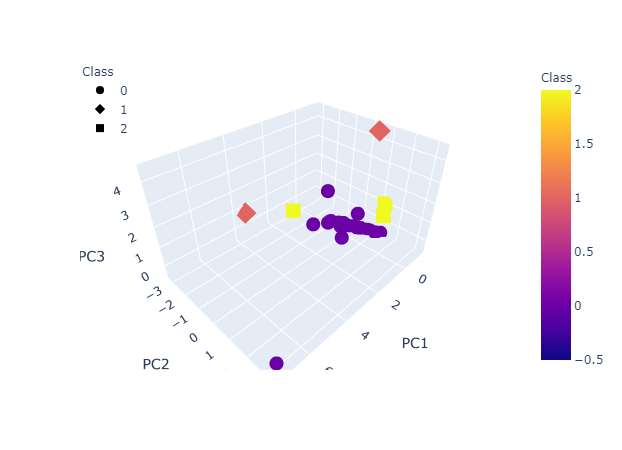

In [32]:
# Create a 3D-Scatter with the PCA data and the clusters
import plotly.express as px
fig = px.scatter_3d(
    clustered_df,
    x="PC1",
    y="PC2",
    z="PC3",
    hover_name='symbol',#need to add 
    hover_data=["sharpe_ratio"],
    color="Class",
    symbol="Class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()